#   LangGraph 활용 - 메시지 그래프 + 리듀서 구현

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

---

## **Reducer (리듀서)**

- **State Reducer**는 LangGraph의 **상태 관리 핵심 메커니즘**

- 각 노드의 출력을 **전체 그래프 상태에 통합**하는 방식을 정의

- **Reducer의 필요성**:

    - **상태 덮어쓰기 문제**: 기본적으로 각 노드의 반환값은 해당 상태 키의 이전 값을 덮어쓰는 방식으로 동작 (override)
    
    - **누적 업데이트 필요**: 특히 메시지 리스트와 같은 경우, 이전 상태에 새로운 값을 추가하고 싶을 때가 있음 

`(1) 기본 Reducer의 동작 방식`

- **Reducer를 지정하지 않으면:**
    - 각 노드의 반환값이 해당 키의 **이전 값을 완전히 덮어씁니다**
    - 이는 `새로운 값 = 노드의 반환값`과 동일한 동작입니다

- **예시로 이해하기:**
    ```python
    # 초기 상태
    state = {"documents": ["doc1.pdf"]}

    # node_2가 실행되어 다음을 반환
    return {"documents": ["doc2.pdf", "doc3.pdf"]}

    # 결과: 이전 값이 사라지고 새 값으로 완전히 대체됨
    state = {"documents": ["doc2.pdf", "doc3.pdf"]}  # doc1.pdf 사라짐!
    ```

- **언제 사용하나요?**
    - 단순 값 업데이트 (문자열, 숫자, 불린 등)
    - 최신 값만 유지하면 되는 경우
    - 예: 현재 쿼리, 최종 요약 결과, 신뢰도 점수

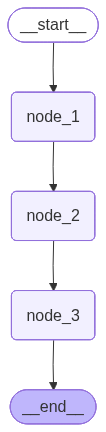

In [3]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 상태 정의 
class DocumentState(TypedDict):
    query: str
    documents: List[str]

# Node 1: query 업데이트
def node_1(state: DocumentState) -> DocumentState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: DocumentState) -> DocumentState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: DocumentState) -> DocumentState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}


# 그래프 빌드
builder = StateGraph(DocumentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))


In [4]:
# 초기 상태
initial_state = {
    "query": "채식주의자를 위한 비건 음식을 추천해주세요."
    }

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("-"*100)
print("최종 상태:")
print("쿼리:", final_state['query'])
print("검색된 문서:", final_state['documents'])

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
----------------------------------------------------------------------------------------------------
최종 상태:
쿼리: 채식주의자를 위한 비건 음식을 추천해주세요.
검색된 문서: ['doc2.pdf', 'doc4.pdf', 'doc5.pdf']


`(2) Reducer를 별도로 지정하는 경우 `

- **Annotated**를 통해 **사용자 정의 Reducer**를 지정할 수 있음 
- **operator.add**를 사용하면 리스트 형태의 데이터를 **누적 관리**할 수 있음 

- operator.add가 리스트에서 작동하는 방식

    ```python
    # operator.add는 Python의 + 연산자와 동일
    [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]

    # 따라서 상태 업데이트 시:
    기존_리스트 = ["doc1.pdf", "doc2.pdf"]
    새로운_리스트 = ["doc3.pdf", "doc4.pdf"]
    결과 = add(기존_리스트, 새로운_리스트)  # ["doc1.pdf", "doc2.pdf", "doc3.pdf", "doc4.pdf"]
    ```

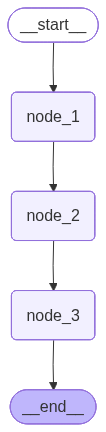

In [5]:
from operator import add
from typing import Annotated, TypedDict, List

class ReducerState(TypedDict):
    query: str
    # Annotated[타입, 리듀서함수] 형식으로 정의
    # add 함수는 left + right 연산을 수행 (리스트의 경우 연결)
    documents: Annotated[List[str], add]

# Node 1: query 업데이트
def node_1(state: ReducerState) -> ReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: ReducerState) -> ReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: ReducerState) -> ReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(ReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# 초기 상태
initial_state = {
    "query": "채식주의자를 위한 비건 음식을 추천해주세요."
    }

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("-"*100)
print("최종 상태:")
print("쿼리:", final_state['query'])
print("검색된 문서:", final_state['documents'])

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
----------------------------------------------------------------------------------------------------
최종 상태:
쿼리: 채식주의자를 위한 비건 음식을 추천해주세요.
검색된 문서: ['doc1.pdf', 'doc2.pdf', 'doc3.pdf', 'doc2.pdf', 'doc4.pdf', 'doc5.pdf']


`(3) Custom Reducer 사용 `

- **Custom Reducer**는 **복잡한 상태 관리**가 필요할 때 사용됨 
- **중복 제거**나 **최대/최소값 유지**와 같은 특수한 로직을 구현할 수 있음 
- 비즈니스 요구사항에 맞는 **맞춤형 상태 관리**가 가능
- 상황에 따라 **조건부 병합**과 같은 고급 기능을 구현할 수 있음 

In [7]:
from typing import TypedDict, List, Annotated

# Custom reducer: 중복된 문서를 제거하며 리스트 병합
def reduce_unique_documents(left: list | None, right: list | None) -> list:
    """
    중복을 제거하면서 순서를 유지하는 리듀서
    
    Args:
        left: 기존 문서 리스트
        right: 새로 추가할 문서 리스트
        
    Returns:
        중복이 제거되고 순서가 유지된 문서 리스트
    """
    if not left:
        left = []
    if not right:
        right = []
    
    # 기존 순서를 유지하면서 중복 제거
    seen = set()
    result = []
    
    for item in left + right:
        if item not in seen:
            seen.add(item)
            result.append(item)
    
    return result

# 상태 정의 (documents 필드 포함)
class CustomReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], reduce_unique_documents]  # Custom Reducer 적용

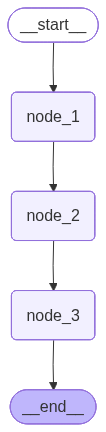

In [8]:
# Node 1: query 업데이트
def node_1(state: CustomReducerState) -> CustomReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: CustomReducerState) -> CustomReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: CustomReducerState) -> CustomReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# 초기 상태
initial_state = {
    "query": "채식주의자를 위한 비건 음식을 추천해주세요."
    }

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("-"*100)
print("최종 상태:")
print("쿼리:", final_state['query'])
print("검색된 문서:", final_state['documents'])

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
----------------------------------------------------------------------------------------------------
최종 상태:
쿼리: 채식주의자를 위한 비건 음식을 추천해주세요.
검색된 문서: ['doc1.pdf', 'doc2.pdf', 'doc3.pdf', 'doc4.pdf', 'doc5.pdf']


---
## **[실습 1]**
- 이전 예제에서 검색된 문서를 내림차순 정렬해서 관리하는 사용자 정의 리듀서를 구현합니다.
- 상태를 새롭게 정의하고, 그래프를 빌드하여 실행합니다.

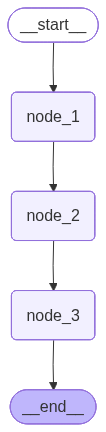

In [10]:
from typing import TypedDict, List, Annotated

# Custom reducer: 중복된 문서를 제거하고 정렬한 후 리스트 병합
def reduce_unique_sorted_documents(left: list | None, right: list | None) -> list:
    """Combine two lists of documents, removing duplicates and sorting."""
    if not left:
        left = []
    if not right:
        right = []
    # 중복 제거: set을 사용하여 중복된 문서를 제거하고 다시 list로 변환
    unique_documents = list(set(left + right))
    # 정렬: 문서 이름을 내림차순으로 정렬
    return sorted(unique_documents, reverse=True)

# 상태 정의 (documents 필드 포함)
class CustomReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], reduce_unique_sorted_documents]  # Custom Reducer 적용

# Node 1: query 업데이트
def node_1(state: CustomReducerState) -> CustomReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: CustomReducerState) -> CustomReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: CustomReducerState) -> CustomReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

<details>
<summary>💡 정답 보기</summary>

```python
from typing import TypedDict, List, Annotated

# Custom reducer: 중복된 문서를 제거하고 정렬한 후 리스트 병합
def reduce_unique_sorted_documents(left: list | None, right: list | None) -> list:
    """Combine two lists of documents, removing duplicates and sorting."""
    if not left:
        left = []
    if not right:
        right = []
    # 중복 제거: set을 사용하여 중복된 문서를 제거하고 다시 list로 변환
    unique_documents = list(set(left + right))
    # 정렬: 문서 이름을 오름차순으로 정렬
    return sorted(unique_documents, reverse=True)

# 상태 정의 (documents 필드 포함)
class CustomReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], reduce_unique_sorted_documents]  # Custom Reducer 적용

# Node 1: query 업데이트
def node_1(state: CustomReducerState) -> CustomReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: CustomReducerState) -> CustomReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: CustomReducerState) -> CustomReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))
```
</details>


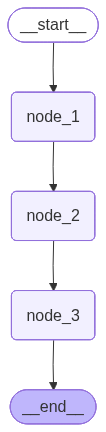

In [11]:
from typing import TypedDict, List, Annotated

# Custom reducer: 중복된 문서를 제거하고 정렬한 후 리스트 병합
def reduce_unique_sorted_documents(left: list | None, right: list | None) -> list:
    """Combine two lists of documents, removing duplicates and sorting."""
    if not left:
        left = []
    if not right:
        right = []
    # 중복 제거: set을 사용하여 중복된 문서를 제거하고 다시 list로 변환
    unique_documents = list(set(left + right))
    # 정렬: 문서 이름을 오름차순으로 정렬
    return sorted(unique_documents, reverse=True)

# 상태 정의 (documents 필드 포함)
class CustomReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], reduce_unique_sorted_documents]  # Custom Reducer 적용

# Node 1: query 업데이트
def node_1(state: CustomReducerState) -> CustomReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: CustomReducerState) -> CustomReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: CustomReducerState) -> CustomReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# 초기 상태
initial_state = {
    "query": "채식주의자를 위한 비건 음식을 추천해주세요."
    }

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("-"*100)
print("최종 상태:")
print("쿼리:", final_state['query'])
print("검색된 문서:", final_state['documents'])

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
----------------------------------------------------------------------------------------------------
최종 상태:
쿼리: 채식주의자를 위한 비건 음식을 추천해주세요.
검색된 문서: ['doc5.pdf', 'doc4.pdf', 'doc3.pdf', 'doc2.pdf', 'doc1.pdf']


---

## **Message 사용**

- **LangGraph**는 **메시지 목록** 기반의 채팅 모델 인터페이스를 활용

- `HumanMessage`와 `AIMessage` 등 다양한 메시지 타입을 지원

- 그래프 상태에서 대화 기록은 **메시지 객체 리스트**로 저장되며, 이를 통해 효율적인 대화 관리를 가능

- **reducer 함수**를 통해 상태 업데이트 시 메시지 목록이 어떻게 갱신될지 정의할 수 있음 

`(1) operator.add`

- 메시지 목록에 새로운 메시지를 간단히 추가하는 기본적인 reducer 함수
    1. `messages` 키가 메시지 리스트를 저장
    2. `add` reducer가 새 메시지를 기존 리스트에 추가
    3. 모든 종류의 메시지(`HumanMessage`, `AIMessage` 등)가 허용됨

- 주의사항:
    - `operator.add`는 단순히 리스트를 연결
    - 중복 메시지도 추가됨
    - 메시지 삭제나 수정은 불가능

In [13]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from operator import add

# 상태 정의
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add]

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# chatbot 노드 함수 정의
def chatbot(state: GraphState) -> GraphState:
    # LLM을 사용하여 챗봇 메시지 생성
    return {"messages": [llm.invoke(state["messages"])]}

In [14]:
# Workflow Graph
builder = StateGraph(GraphState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 초기 상태
initial_state = {"messages": [("user", "안녕하세요!")]}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    pprint(event['messages'])
    print("-"*100)

[('user', '안녕하세요!')]
----------------------------------------------------------------------------------------------------
[('user', '안녕하세요!'),
 AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'id': 'chatcmpl-CVyQUvf6O9CdrtIcyaYrQaFa6SJBz', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--87610d51-572b-47ed-b6e0-03cb974153ce-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
-----

`(2) add_messages`

- 메시지 ID를 기반으로 기존 메시지를 업데이트하거나 새 메시지를 추가하는 고급 관리 기능을 제공
    - 새 메시지는 기존 목록에 추가
    - 기존 메시지 업데이트도 올바르게 처리 (메시지 ID를 추적)

- 기존 메시지의 중복 추가를 방지

In [15]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# add_messages 사용 상태 정의
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# chatbot 노드 함수 정의
def chatbot(state: GraphState) -> GraphState:
    # LLM을 사용하여 챗봇 메시지 생성
    return {"messages": [llm.invoke(state["messages"])]}

# Workflow Graph
builder = StateGraph(GraphState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 초기 상태
initial_state = {"messages": [("user", "안녕하세요!")]}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    pprint(event['messages'])
    print("-"*100)

[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='34a81c26-5c26-4c33-adc7-b6f52dc0b839')]
----------------------------------------------------------------------------------------------------
[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='34a81c26-5c26-4c33-adc7-b6f52dc0b839'),
 AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'id': 'chatcmpl-CVyQVKftcveejCDS9uRCxHciq0cAW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--11a96505-b081-44bb-a21b-7a0225943fe

**[참고] operator.add vs add_messages 상세 비교**

| 특성 | operator.add | add_messages |
|------|-------------|--------------|
| **기본 동작** | 리스트 연결 (`+`) | 메시지 ID 기반 관리 |
| **중복 처리** | 중복 허용 | ID로 중복 감지 |
| **메시지 수정** | 불가능 | 같은 ID 메시지 업데이트 가능 |
| **메시지 포맷** | 명시적 객체만 | 다양한 포맷 자동 변환 |
| **사용 사례** | 단순 리스트 누적 | 채팅 대화 관리 |


`(3) MessagesState`

- **`MessagesState`** 는 메시지 관리를 위해 미리 정의된 상태 타입

- 이 상태는 **`add_messages` reducer**를 기본으로 사용하여 메시지 업데이트를 자동으로 처리

- `AnyMessage` 객체 리스트를 포함하는 **단일 `messages` 키**로 구성되어 있어 구조가 단순함 

- **MessagesState를 사용하는 이유**

    1. **코드 간결화**
        ```python
        # 이전 방식
        class State(TypedDict):
            messages: Annotated[list[AnyMessage], add_messages]
        
        # MessagesState 사용
        class State(MessagesState):
            pass  # messages 필드가 자동으로 포함됨
        ```

    2. **표준화된 패턴**
        - LangGraph 커뮤니티에서 널리 사용되는 표준
        - 다른 개발자가 코드를 이해하기 쉬움
        - 문서와 예제에서 일관된 패턴

    3. **확장 가능성**
        ```python
        class CustomState(MessagesState):
            # 기본 messages 필드는 유지하면서
            user_id: str  # 추가 필드
            session_info: dict  # 추가 필드
            emotion: Optional[str]  # 추가 필드
        ```

In [16]:
from langgraph.graph import MessagesState

# messages 키를 가진 상태 생성 (messages 키는 기본 제공)
class GraphState(MessagesState):  # MessagesState 상속
    ... 
    # 추가적인 필드 정의 가능
    # custom_field: str

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4o-mini")

# chatbot 노드 함수 정의
def chatbot(state: GraphState) -> GraphState:
    # LLM을 사용하여 챗봇 메시지 생성
    return {"messages": [llm.invoke(state["messages"])]}

# Workflow Graph
builder = StateGraph(GraphState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 초기 상태
initial_state = {"messages": [("user", "안녕하세요!")]}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    pprint(event['messages'])
    print("-"*100)

[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='31ead201-3b5d-4671-990d-ab63662fe58b')]
----------------------------------------------------------------------------------------------------
[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='31ead201-3b5d-4671-990d-ab63662fe58b'),
 AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CVyQWwEeQHnI2Rc5uNJcmUghcL3fK', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--fe71ee33-78fa-48ed-9fa8-60cd78ac84ea

`(4) MessagesState 커스텀 필드 추가`

- **MessagesState**를 상속받아 추가 필드를 포함하는 새로운 상태 타입을 정의할 수 있음 

- 기존 `messages` 키의 **`add_messages` reducer** 기능을 그대로 유지

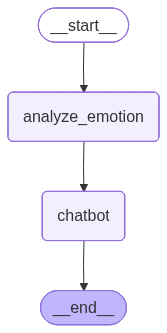

In [17]:
from typing import Optional
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI

# MessagesState를 상속하여 커스텀 필드 추가
class GraphState(MessagesState):
    # 사용자의 감정 상태를 추적하는 필드 추가
    emotion: Optional[str] 

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# 감정 분석을 위한 프롬프트 템플릿
EMOTION_PROMPT = """
사용자의 메시지를 분석하여 감정 상태를 파악해주세요.
가능한 감정 상태: 행복, 슬픔, 화남, 중립

사용자 메시지: {message}

감정 상태만 한 단어로 답변해주세요.
"""

# 감정 분석 노드
def analyze_emotion(state: GraphState) -> GraphState:
    # 가장 최근 사용자 메시지 가져오기
    last_message = state["messages"][-1].content
    
    # 감정 분석 실행
    emotion_analysis = llm.invoke(EMOTION_PROMPT.format(message=last_message))
    
    # 상태 업데이트
    return {
        "emotion": emotion_analysis.content.strip()
    }

# 챗봇 응답 노드
def chatbot(state: GraphState) -> GraphState:
    # 현재 감정 상태를 고려한 시스템 메시지 생성
    system_message = f"""
    사용자의 현재 감정 상태는 {state['emotion']}입니다.
    이를 고려하여 공감적이고 적절한 응답을 해주세요.
    """
    
    # 기존 메시지에 시스템 메시지 추가
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    
    # LLM 응답 생성
    response = llm.invoke(messages)
    
    return {"messages": [response]}

# Workflow Graph 구성
builder = StateGraph(GraphState)

# 노드 추가
builder.add_node("analyze_emotion", analyze_emotion)
builder.add_node("chatbot", chatbot)

# 엣지 추가
builder.add_edge(START, "analyze_emotion")
builder.add_edge("analyze_emotion", "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
# 초기 상태
initial_state = {
    "messages": [
        {"role": "user", "content": "오늘 정말 힘든 하루였어요..."}
        ]
}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    if "emotion" in event:
        print(f"감정 상태: {event['emotion']}")
    if "messages" in event:
        print("메시지:")
        for msg in event["messages"]:
            print(f"{msg.type}: {msg.content}")
    print("-"*100)

메시지:
human: 오늘 정말 힘든 하루였어요...
----------------------------------------------------------------------------------------------------
감정 상태: 슬픔
메시지:
human: 오늘 정말 힘든 하루였어요...
----------------------------------------------------------------------------------------------------
감정 상태: 슬픔
메시지:
human: 오늘 정말 힘든 하루였어요...
ai: 정말 많이 힘드셨나 봐요. 이렇게 힘든 날이 있을 때는 마음도 지치고 무거워지기 쉽죠. 혹시 어떤 일 때문에 그렇게 힘들었는지 이야기해도 괜찮다면 들어드릴게요. 혼자 감당하기 어려울 때 이렇게 말하는 것만으로도 조금은 마음이 가벼워질 수 있답니다.
----------------------------------------------------------------------------------------------------


---
## **[실습 2]**

- 문제: 주어진 텍스트에 대해 검색-요약-팩트체크의 3단계 파이프라인을 구현하는 LangGraph 워크플로우를 작성하세요.

- 입력/출력:
  * 입력: 검색할 주제나 질문
  * 출력: 관련 정보 검색 결과, 요약본, 팩트체크 결과

- 제약사항:
  * LangGraph의 StateGraph를 사용하여 구현
  * 최소 3개의 노드(검색, 요약, 팩트체크) 구현
  * MessagesState를 상속한 커스텀 상태 클래스 사용
  * 각 단계의 신뢰도 점수 포함
  * Tavily 검색 사용

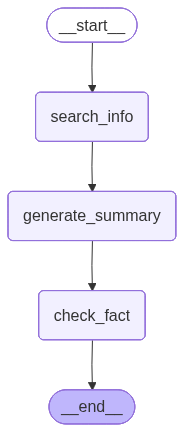

C:\Users\kaydash\AppData\Local\Temp\ipykernel_35500\2858267173.py:24: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=3)


팩트체크 중 오류 발생: Error code: 400 - {'error': {'message': "Invalid schema for response_format 'FactCheckResult': In context=(), 'required' is required to be supplied and to be an array including every key in properties. Extra required key 'scores' supplied.", 'type': 'invalid_request_error', 'param': 'response_format', 'code': None}}
검색 결과 수: 3
검색 결과: ['title: AI의 환경 영향과 지속 가능성을 위한 조직의 행동 방안 - 시냅토리 \n content: 콘텐츠로 건너뛰기\n\n(주)온피아에서 제공 | 1899-8703\n\n무료구독\n\n로그인\n\n## 블로그\n\n# AI의 환경 영향과 지속 가능성을 위한 조직의 행동 방안\n\n#### AI의 환경적 영향과 지속 가능한 활용 방안\n\n인공지능(AI)의 활용은 데이터를 처리하고 분석하는 능력 때문에 세계 여러 산업에서 혁신을 가능하게 했지만, 그로 인한 환경적 영향은 종종 간과됩니다. AI는 많은 에너지와 물을 소비하며, 이러한 자원 소비는 글로벌 온실가스(GHG) 배출에도 기여합니다. 그러나 아이러니하게도 AI는 또 다른 방식으로 기후 변화에 대처하는 도구로도 사용될 수 있습니다.\n\n##### AI의 에너지 및 물 소비 [...] AI가 환경에 미치는 부정적 영향에도 불구하고, 이러한 기술이 제공하는 이점은 여전히 커다란 기회를 제공합니다. 지속 가능한 AI 전략을 채택함으로써, 우리는 AI의 긍정적 잠재력을 최대화하고 환경적인 영향을 최소화할 수 있습니다. 지금이 그 행동을 시작할 때입니다.\n\n출처 : 세계경제포럼(WEF)의 “How AI Use Impacts the Environment and What You Can Do 

h:\miniconda3\envs\modu3\Lib\site-packages\langchain_openai\chat_models\base.py:445: UserWarning: Invalid schema for OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. Specify `method="function_calling"` instead or update your schema. See supported schemas: https://platform.openai.com/docs/guides/structured-outputs#supported-schemas
  warnings.warn(message)


In [19]:
from typing import Optional, List, Dict
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from pydantic import BaseModel, Field

class ResearchState(MessagesState):
    search_results: Optional[List[str]]
    summary: Optional[str]
    fact_check: Optional[Dict[str, float]]

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4o-mini")

# 팩트체크 결과를 위한 개선된 스키마
class FactCheckResult(BaseModel):
    """팩트체크 결과를 위한 스키마"""
    scores: Dict[str, float] = Field(
        description="각 문장에 대한 신뢰도 점수 (0-1 사이의 값). 키는 문장 번호(예: '1', '2'), 값은 신뢰도 점수"
    )
    
# 검색 노드
def search_info(state: ResearchState) -> ResearchState:
    search_tool = TavilySearchResults(max_results=3)
    query = state["messages"][-1].content
    
    # 검색 실행
    results = search_tool.invoke(query)

    # 상위 3개 결과만 사용 (content 필드)
    fact_check_results = [f"title: {item['title']} \n content: {item['content']} \n url: {item['url']}" for item in results][:3]
    
    return {
        "search_results": fact_check_results  
    }

# 요약 노드
def generate_summary(state: ResearchState) -> ResearchState:
    if not state["search_results"]:
        return {"summary": "검색 결과가 없습니다."}
    
    summary_prompt = """
    다음 검색 결과들을 요약해주세요:
    {search_results}
    
    핵심 포인트 3-4개로 간단히 요약:
    """
    
    summary = llm.invoke(summary_prompt.format(
        search_results="\n".join(state["search_results"])
    ))
    
    return {"summary": summary.content}

# 팩트체크 노드
def check_fact(state: ResearchState) -> ResearchState:
    """요약 내용에 대한 팩트체크를 수행하는 노드"""
    
    if not state["summary"]:
        return {"fact_check": {"scores": {}}}
    
    fact_check_prompt = """다음 요약 내용의 각 문장에 대해 신뢰도를 평가해주세요.

요약 내용:
{summary}

각 문장의 신뢰도를 0과 1 사이의 숫자로 평가하여 JSON 형식으로 반환해주세요.
신뢰도가 높을수록 1에 가깝고, 낮을수록 0에 가깝습니다.

예시 응답 형식:
{{
    "scores": {{
        "1": 0.9,  # 첫 번째 문장의 신뢰도
        "2": 0.7,  # 두 번째 문장의 신뢰도
        "3": 0.85  # 세 번째 문장의 신뢰도
    }}
}}

요약의 각 문장을 평가하여 위와 같은 형식으로 신뢰도 점수를 반환해주세요."""
    
    fact_checker = llm.with_structured_output(FactCheckResult)
    
    try:
        result = fact_checker.invoke(
            fact_check_prompt.format(summary=state["summary"])
        )
        return {"fact_check": result.model_dump()}
        
    except Exception as e:
        print(f"팩트체크 중 오류 발생: {str(e)}")
        return {"fact_check": {"scores": {}}}

# 그래프 구성
builder = StateGraph(ResearchState)

builder.add_node("search_info", search_info)
builder.add_node("generate_summary", generate_summary)
builder.add_node("check_fact", check_fact)

builder.add_edge(START, "search_info")
builder.add_edge("search_info", "generate_summary")
builder.add_edge("generate_summary", "check_fact")
builder.add_edge("check_fact", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))        

result = graph.invoke({
    "messages": [{"role": "user", "content": "인공지능의 환경적 영향은?"}]
})

print(f"검색 결과 수: {len(result['search_results'])}")
print("검색 결과:", result["search_results"])
print("-" * 100)
print(f"요약: {result['summary']}")
print(f"팩트체크 결과: {result['fact_check']}")

<details>
<summary>💡 정답 보기</summary>

```python
from typing import Optional, List, Dict
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from pydantic import BaseModel, Field

class ResearchState(MessagesState):
    search_results: Optional[List[str]]
    summary: Optional[str]
    fact_check: Optional[Dict[str, float]]

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# 팩트체크 결과를 위한 개선된 스키마
class FactCheckResult(BaseModel):
    """팩트체크 결과를 위한 스키마"""
    scores: Dict[str, float] = Field(
        description="각 문장에 대한 신뢰도 점수 (0-1 사이의 값). 키는 문장 번호(예: '1', '2'), 값은 신뢰도 점수"
    )
    
# 검색 노드
def search_info(state: ResearchState) -> ResearchState:
    search_tool = TavilySearchResults(max_results=3)
    query = state["messages"][-1].content
    
    # 검색 실행
    results = search_tool.invoke(query)

    # 상위 3개 결과만 사용 (content 필드)
    fact_check_results = [f"title: {item['title']} \n content: {item['content']} \n url: {item['url']}" for item in results][:3]
    
    return {
        "search_results": fact_check_results  
    }

# 요약 노드
def generate_summary(state: ResearchState) -> ResearchState:
    if not state["search_results"]:
        return {"summary": "검색 결과가 없습니다."}
    
    summary_prompt = """
    다음 검색 결과들을 요약해주세요:
    {search_results}
    
    핵심 포인트 3-4개로 간단히 요약:
    """
    
    summary = llm.invoke(summary_prompt.format(
        search_results="\n".join(state["search_results"])
    ))
    
    return {"summary": summary.content}

from pydantic import BaseModel, Field


class FactCheckResult(BaseModel):
    """팩트체크 결과를 위한 스키마"""
    confidence: str = Field(
        description="문장에 대한 팩트체크 신뢰도 점수 (0-1 사이의 값)"
    )

# 팩트체크 노드
def check_fact(state: ResearchState) -> ResearchState:
    """요약 내용에 대한 팩트체크를 수행하는 노드"""
    
    if not state["summary"]:
        return {"fact_check": {"scores": {}}}
    
    fact_check_prompt = """다음 요약 내용의 각 문장에 대해 신뢰도를 평가해주세요.

요약 내용:
{summary}

각 문장의 신뢰도를 0과 1 사이의 숫자로 평가하여 JSON 형식으로 반환해주세요.
신뢰도가 높을수록 1에 가깝고, 낮을수록 0에 가깝습니다.

예시 응답 형식:
{{
    "scores": {{
        "1": 0.9,  # 첫 번째 문장의 신뢰도
        "2": 0.7,  # 두 번째 문장의 신뢰도
        "3": 0.85  # 세 번째 문장의 신뢰도
    }}
}}

요약의 각 문장을 평가하여 위와 같은 형식으로 신뢰도 점수를 반환해주세요."""
    
    fact_checker = llm.with_structured_output(FactCheckResult)
    
    try:
        result = fact_checker.invoke(
            fact_check_prompt.format(summary=state["summary"])
        )
        return {"fact_check": result.model_dump()}
        
    except Exception as e:
        print(f"팩트체크 중 오류 발생: {str(e)}")
        return {"fact_check": {"scores": {}}}

# 그래프 구성
builder = StateGraph(ResearchState)

builder.add_node("search_info", search_info)
builder.add_node("generate_summary", generate_summary)
builder.add_node("check_fact", check_fact)

builder.add_edge(START, "search_info")
builder.add_edge("search_info", "generate_summary")
builder.add_edge("generate_summary", "check_fact")
builder.add_edge("check_fact", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
# display(Image(graph.get_graph().draw_mermaid_png()))        

result = graph.invoke({
    "messages": [{"role": "user", "content": "인공지능의 환경적 영향은?"}]
})

print(f"검색 결과 수: {len(result['search_results'])}")
print("검색 결과:", result["search_results"])
print("-" * 100)
print(f"요약: {result['summary']}")
print(f"팩트체크 결과: {result['fact_check']}")

```
</details>


In [20]:
from typing import Optional, List, Dict
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from pydantic import BaseModel, Field

class ResearchState(MessagesState):
    search_results: Optional[List[str]]
    summary: Optional[str]
    fact_check: Optional[Dict[str, float]]

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# 팩트체크 결과를 위한 개선된 스키마
class FactCheckResult(BaseModel):
    """팩트체크 결과를 위한 스키마"""
    scores: Dict[str, float] = Field(
        description="각 문장에 대한 신뢰도 점수 (0-1 사이의 값). 키는 문장 번호(예: '1', '2'), 값은 신뢰도 점수"
    )
    
# 검색 노드
def search_info(state: ResearchState) -> ResearchState:
    search_tool = TavilySearchResults(max_results=3)
    query = state["messages"][-1].content
    
    # 검색 실행
    results = search_tool.invoke(query)

    # 상위 3개 결과만 사용 (content 필드)
    fact_check_results = [f"title: {item['title']} \n content: {item['content']} \n url: {item['url']}" for item in results][:3]
    
    return {
        "search_results": fact_check_results  
    }

# 요약 노드
def generate_summary(state: ResearchState) -> ResearchState:
    if not state["search_results"]:
        return {"summary": "검색 결과가 없습니다."}
    
    summary_prompt = """
    다음 검색 결과들을 요약해주세요:
    {search_results}
    
    핵심 포인트 3-4개로 간단히 요약:
    """
    
    summary = llm.invoke(summary_prompt.format(
        search_results="\n".join(state["search_results"])
    ))
    
    return {"summary": summary.content}

In [21]:
from pydantic import BaseModel, Field


class FactCheckResult(BaseModel):
    """팩트체크 결과를 위한 스키마"""
    confidence: str = Field(
        description="문장에 대한 팩트체크 신뢰도 점수 (0-1 사이의 값)"
    )

# 팩트체크 노드
def check_fact(state: ResearchState) -> ResearchState:
    """요약 내용에 대한 팩트체크를 수행하는 노드"""
    
    if not state["summary"]:
        return {"fact_check": {"scores": {}}}
    
    fact_check_prompt = """다음 요약 내용의 각 문장에 대해 신뢰도를 평가해주세요.

요약 내용:
{summary}

각 문장의 신뢰도를 0과 1 사이의 숫자로 평가하여 JSON 형식으로 반환해주세요.
신뢰도가 높을수록 1에 가깝고, 낮을수록 0에 가깝습니다.

예시 응답 형식:
{{
    "scores": {{
        "1": 0.9,  # 첫 번째 문장의 신뢰도
        "2": 0.7,  # 두 번째 문장의 신뢰도
        "3": 0.85  # 세 번째 문장의 신뢰도
    }}
}}

요약의 각 문장을 평가하여 위와 같은 형식으로 신뢰도 점수를 반환해주세요."""
    
    fact_checker = llm.with_structured_output(FactCheckResult)
    
    try:
        result = fact_checker.invoke(
            fact_check_prompt.format(summary=state["summary"])
        )
        return {"fact_check": result.model_dump()}
        
    except Exception as e:
        print(f"팩트체크 중 오류 발생: {str(e)}")
        return {"fact_check": {"scores": {}}}

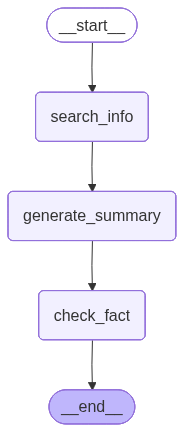

In [22]:
# 그래프 구성
builder = StateGraph(ResearchState)

builder.add_node("search_info", search_info)
builder.add_node("generate_summary", generate_summary)
builder.add_node("check_fact", check_fact)

builder.add_edge(START, "search_info")
builder.add_edge("search_info", "generate_summary")
builder.add_edge("generate_summary", "check_fact")
builder.add_edge("check_fact", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
result = graph.invoke({
    "messages": [{"role": "user", "content": "인공지능의 환경적 영향은?"}]
})

print(f"검색 결과 수: {len(result['search_results'])}")
print("검색 결과:", result["search_results"])
print("-" * 100)
print(f"요약: {result['summary']}")
print(f"팩트체크 결과: {result['fact_check']}")

검색 결과 수: 3
검색 결과: ['title: AI의 환경 영향과 지속 가능성을 위한 조직의 행동 방안 - 시냅토리 \n content: 콘텐츠로 건너뛰기\n\n(주)온피아에서 제공 | 1899-8703\n\n무료구독\n\n로그인\n\n## 블로그\n\n# AI의 환경 영향과 지속 가능성을 위한 조직의 행동 방안\n\n#### AI의 환경적 영향과 지속 가능한 활용 방안\n\n인공지능(AI)의 활용은 데이터를 처리하고 분석하는 능력 때문에 세계 여러 산업에서 혁신을 가능하게 했지만, 그로 인한 환경적 영향은 종종 간과됩니다. AI는 많은 에너지와 물을 소비하며, 이러한 자원 소비는 글로벌 온실가스(GHG) 배출에도 기여합니다. 그러나 아이러니하게도 AI는 또 다른 방식으로 기후 변화에 대처하는 도구로도 사용될 수 있습니다.\n\n##### AI의 에너지 및 물 소비 [...] AI가 환경에 미치는 부정적 영향에도 불구하고, 이러한 기술이 제공하는 이점은 여전히 커다란 기회를 제공합니다. 지속 가능한 AI 전략을 채택함으로써, 우리는 AI의 긍정적 잠재력을 최대화하고 환경적인 영향을 최소화할 수 있습니다. 지금이 그 행동을 시작할 때입니다.\n\n출처 : 세계경제포럼(WEF)의 “How AI Use Impacts the Environment and What You Can Do About It” (2025년 6월 1일)에서 발췌  \n원문 링크 바로가기\n\nPrevPrevious인공지능 시대에도 고객이 원하는 것은 여전히 인간의 도움이다\n\nNext아시아 태평양(APAC) 지역에서 기술 발전이 고객 경험을 변화시키는 9가지 방법Next\n\n뉴스(토픽)\n\n## AI가 콜센터 에이전트를 향상시키고 있는가, 아니면 대체하고 있는가?\n\nRead More »\n\n2025년 09월 01일\n\n뉴스(토픽)\n\n## 클라우드 네이티브 컨택센터가 고객 충성도 전쟁에서 승리하는 이유 [...] 최근 몇 년간 클라우드 컴퓨팅과 디지털 서비스에 대한 수요는 데이터 

---

## **병렬 처리**

- **분기(branching)** 기능을 통해 LangGraph에서 노드의 병렬 실행이 가능

- 병렬 처리는 **독립적인 작업**들을 동시에 실행함으로써 전체 처리 시간을 단축

- 다양한 데이터 소스에서 **정보 수집 및 처리**가 필요한 경우 병렬 실행이 특히 효과적

`(1) 기본 Fan-out/Fan-in (필수)`

- **Fan-out** 구조는 하나의 노드에서 여러 병렬 노드로 데이터를 분산시키는 방식을 구현

- **Fan-in** 구조는 병렬로 처리된 여러 노드의 결과를 단일 노드에서 취합하는 역할

- 가장 기본적이고 직관적인 병렬 처리 구조

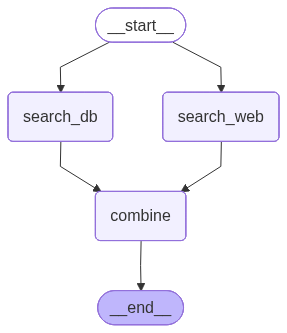

In [24]:
"""
두 개의 데이터 소스에서 동시에 정보를 가져오기
"""
import operator
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END

class SearchState(TypedDict):
    query: str  # 검색어
    results: Annotated[list[str], operator.add]  # 결과 누적

def search_db(state: SearchState):
    """데이터베이스 검색 (시뮬레이션)"""
    print(f"📊 DB 검색 중: {state['query']}")
    return {"results": ["DB: 관련 데이터 1", "DB: 관련 데이터 2"]}

def search_web(state: SearchState):
    """웹 검색 (시뮬레이션)"""
    print(f"🌐 웹 검색 중: {state['query']}")
    return {"results": ["웹: 최신 정보 1", "웹: 최신 정보 2"]}

def combine_results(state: SearchState):
    """검색 결과 통합"""
    print(f"✅ 총 {len(state['results'])}개 결과 수집 완료")
    return {"results": [f"[통합됨] 총 {len(state['results'])}개 결과"]}

# 그래프 구성
builder = StateGraph(SearchState)
builder.add_node("search_db", search_db)
builder.add_node("search_web", search_web)
builder.add_node("combine", combine_results)

# 병렬 실행: START에서 두 검색 노드로 동시 분기
builder.add_edge(START, "search_db")
builder.add_edge(START, "search_web")

# 두 검색이 완료되면 combine으로 합침
builder.add_edge("search_db", "combine")
builder.add_edge("search_web", "combine")
builder.add_edge("combine", END)

graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))


In [25]:
# 실행 및 결과 확인
print("=== 병렬 검색 시작 ===")
result = graph.invoke({
        "query": "LangGraph 튜토리얼"
    })
print("\n=== 최종 결과 ===")
for r in result["results"]:
    print(f"  - {r}")

=== 병렬 검색 시작 ===
📊 DB 검색 중: LangGraph 튜토리얼
🌐 웹 검색 중: LangGraph 튜토리얼
✅ 총 4개 결과 수집 완료

=== 최종 결과 ===
  - DB: 관련 데이터 1
  - DB: 관련 데이터 2
  - 웹: 최신 정보 1
  - 웹: 최신 정보 2
  - [통합됨] 총 4개 결과


`(2) 조건부 엣지를 사용한 분기 (Conditional Branching)`

- **Fan-out** 구조는 하나의 노드에서 여러 병렬 노드로 데이터를 분산시키는 방식을 구현

- **Fan-in** 구조는 병렬로 처리된 여러 노드의 결과를 단일 노드에서 취합하는 역할

- 가장 기본적이고 직관적인 병렬 처리 구조

**구현 예시**

- 초기 그리팅 후 조건부로 서비스를 실행
- 선택된 서비스들을 병렬로 실행
- 모든 서비스 실행 후 최종 처리를 수행
- 전체 과정의 상태를 추적

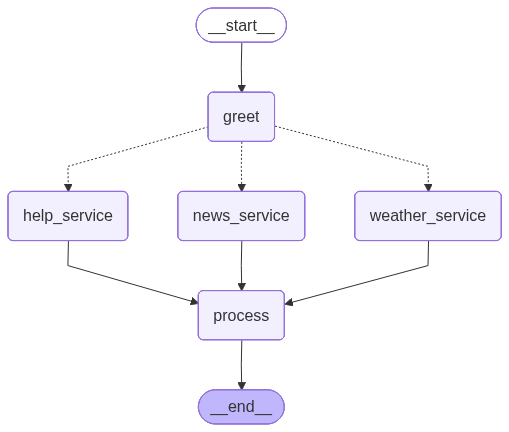

In [26]:
import operator
from typing import Annotated, Sequence, TypedDict
from langgraph.graph import StateGraph, START, END

# 상태 정의: aggregate 리스트와 라우팅을 위한 user_intent 필드 포함
class ChatState(TypedDict):
    messages: Annotated[list, operator.add]  # aggregate 대신 messages 사용
    user_intent: str  # 라우팅 조건

# 서비스 노드 정의
def greet_service(state: ChatState):
    print(f'Adding "greet" to {state["messages"]}')
    return {"messages": ["Hello!"]} 

def weather_service(state: ChatState):
    print(f'Adding "weather" to {state["messages"]}')
    return {"messages": ["The weather is sunny."]}

def news_service(state: ChatState):
    print(f'Adding "news" to {state["messages"]}')
    return {"messages": ["Here's the latest news."]}

def help_service(state: ChatState):
    print(f'Adding "help" to {state["messages"]}')
    return {"messages": ["How can I help you?"]}

def process_response(state: ChatState):
    print(f'Adding "process" to {state["messages"]}')
    return {"messages": ["Processing complete."]}

# 라우팅 함수: user_intent 값에 따라 서비스 노드 결정
def route_services(state: ChatState) -> Sequence[str]:
    if state["user_intent"] == "weather_news":
        # 날씨와 뉴스 서비스를 병렬 실행
        return ["weather_service", "news_service"]
    
    # 기본적으로 인사와 뉴스 서비스를 병렬 실행
    return ["help_service", "news_service"]

# 그래프 구성
chat_builder = StateGraph(ChatState)

# 노드 추가
chat_builder.add_node("greet", greet_service)
chat_builder.add_node("weather_service", weather_service)
chat_builder.add_node("news_service", news_service)
chat_builder.add_node("help_service", help_service)
chat_builder.add_node("process", process_response)

# 엣지 추가
chat_builder.add_edge(START, "greet")

# 중간 노드 정의
intermediates = ["weather_service", "news_service", "help_service"]

# greet 노드에서 조건부 엣지 추가
chat_builder.add_conditional_edges(
    "greet",
    route_services,
    intermediates,
)

# 중간 노드들을 process 노드에 연결
for node in intermediates:
    chat_builder.add_edge(node, "process")

chat_builder.add_edge("process", END)

# 그래프 컴파일
chat_graph = chat_builder.compile()

# 그래프 시각화
display(Image(chat_graph.get_graph().draw_mermaid_png()))

In [27]:
# "weather_news" 의도를 가지고 실행
chat_graph.invoke({
        "user_intent": "weather_news"
    })

Adding "greet" to []
Adding "news" to ['Hello!']
Adding "weather" to ['Hello!']
Adding "process" to ['Hello!', "Here's the latest news.", 'The weather is sunny.']


{'messages': ['Hello!',
  "Here's the latest news.",
  'The weather is sunny.',
  'Processing complete.'],
 'user_intent': 'weather_news'}

In [28]:
# 다른 의도를 가지고 실행
chat_graph.invoke({
        "user_intent": "news"
    })

Adding "greet" to []
Adding "help" to ['Hello!']
Adding "news" to ['Hello!']
Adding "process" to ['Hello!', 'How can I help you?', "Here's the latest news."]


{'messages': ['Hello!',
  'How can I help you?',
  "Here's the latest news.",
  'Processing complete.'],
 'user_intent': 'news'}

`(3) 다단계 분기 (Multi-step Parallel Paths)`

- **다단계 분기**는 각각의 병렬 경로에서 여러 단계의 독립적인 처리를 지원 

- 각 분기는 **서로 다른 데이터 처리 파이프라인**을 포함할 수 있어, 복잡한 워크플로우 구현이 가능

- 최종적으로 각 분기의 결과는 하나의 노드에서 **통합되어 처리**될 수 있음 

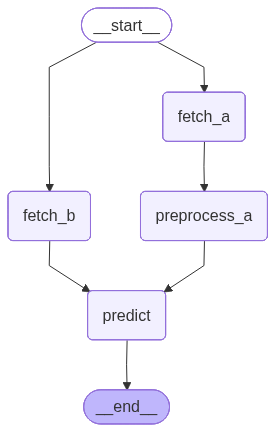

In [29]:
# 데이터 전처리와 모델 예측을 병렬로 수행하기

import operator
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END

class ModelState(TypedDict):
    data: Annotated[list, operator.add]

def fetch_data_a(state: ModelState):
    return {"data": ["Data A1"]}

def preprocess_data_a(state: ModelState):
    return {"data": ["Preprocessed A1"]}

def fetch_data_b(state: ModelState):
    return {"data": ["Data B1"]}

def make_prediction(state: ModelState):
    return {"data": ["Prediction from A and B"]}

model_builder = StateGraph(ModelState)
model_builder.add_node("fetch_a", fetch_data_a)
model_builder.add_node("preprocess_a", preprocess_data_a)
model_builder.add_node("fetch_b", fetch_data_b)
model_builder.add_node("predict", make_prediction)

model_builder.add_edge(START, "fetch_a")
model_builder.add_edge(START, "fetch_b")
model_builder.add_edge("fetch_a", "preprocess_a")
model_builder.add_edge(["preprocess_a", "fetch_b"], "predict")
model_builder.add_edge("predict", END)

model_graph = model_builder.compile()

display(Image(model_graph.get_graph().draw_mermaid_png()))

In [30]:
# 그래프 실행
model_graph.invoke({"data": []})

{'data': ['Data A1', 'Data B1', 'Preprocessed A1', 'Prediction from A and B']}

`(4) 동적 엣지 생성 및 개별 상태 전달하기 (Map-Reduce 패턴)`

- **기본 동작의 한계**

    - 기본적으로 LangGraph의 노드와 엣지는 미리 정의되며, 모든 노드는 동일한 공유 상태(shared state)를 사용함. 하지만 다음과 같은 경우에는 문제가 발생할 수 있음. 

    -  **동적 엣지:** 실행 시점에 따라 연결해야 할 노드의 수가 달라지는 경우 (예: 입력 데이터에 따라 다른 개수의 하위 작업을 생성해야 하는 경우)
    -  **개별 상태:** 각 노드가 독립적인 상태를 가지고 작업해야 하는 경우 (예: 각 하위 작업이 서로 다른 데이터를 처리해야 하는 경우)

- **Map-Reduce 패턴**

    1.  **Map:**  하나의 노드(mapper)가 여러 개의 객체(또는 작업)를 생성
    2.  **Reduce:** 다른 노드(reducer)가 mapper가 생성한 객체들을 처리하고 결과를 결합

-  **`Send` 객체**

    - LangGraph에서는 `Send` 객체를 사용하여 map 단계를 구현할 수 있음 
    - `Send` 객체는 조건부 엣지(`add_conditional_edges`)의 `condition_function`에서 반환될 수 있으며, 다음과 같은 두 가지 인수를 받아서 구현

        1.  **`node_name` (str):**  실행할 노드의 이름
        2.  **`state` (dict):** 해당 노드에 전달할 개별 상태


    - **기존 방식의 한계:**
        ```python
        # ❌ 문제: URL 개수를 미리 알아야 함
        builder.add_edge(START, "scrape_url_1")
        builder.add_edge(START, "scrape_url_2")
        builder.add_edge(START, "scrape_url_3")
        # URL이 5개면? 10개면? 매번 수정해야 함!
        ```

    - **Send를 사용하면:**
        ```python
        # ✅ 해결: 실행 시점에 URL 개수만큼 자동으로 분기
        def route_to_scraping(state):
            return [Send("scrape_url", {"url": url}) for url in state["urls"]]
            # URLs가 3개든 100개든 자동으로 처리!
        ```

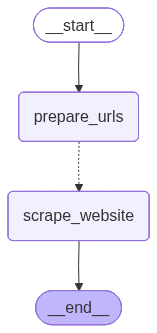

In [31]:
#### 예제: 웹사이트 스크래핑
from typing import Annotated, List, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
import operator
import time

# 1️⃣ 전체 상태 정의 (모든 노드가 공유)
class WebScrapingState(TypedDict):
    urls: List[str]  # 스크래핑할 URL 목록
    scraped_data: Annotated[List[dict], operator.add]  # 결과 누적

# 2️⃣ URL 목록을 정의하는 노드
def prepare_urls(state: WebScrapingState) -> WebScrapingState:
    """스크래핑할 URL 목록 준비"""
    urls = state["urls"]
    print(f"📋 총 {len(urls)}개 URL 준비 완료")
    return {"urls": urls}

# 3️⃣ 개별 URL을 스크래핑하는 노드
def scrape_website(state: dict) -> WebScrapingState:  # ⚠️ 주의: 전체 상태가 아닌 부분 상태!
    """
    각 웹사이트를 스크래핑합니다.
    
    Args:
        state: {"url": "https://example.com"} 형태의 부분 상태
        
    Returns:
        scraped_data에 추가할 데이터
    """
    url = state["url"]  # Send로 전달받은 개별 URL
    print(f"🔍 스크래핑 중: {url}")
    time.sleep(0.5)  # 실제 스크래핑 시뮬레이션
    
    # 스크래핑 결과 반환 (전체 상태에 누적됨)
    return {
        "scraped_data": [{
            "url": url,
            "title": f"{url}의 제목",
            "content": f"{url}의 내용 요약..."
        }]
    }

# 4️⃣ Send를 사용한 동적 라우팅
def route_to_scraping(state: WebScrapingState) -> List[Send]:
    """
    각 URL에 대해 scrape_website 노드를 병렬로 실행
    
    Returns:
        Send 객체 리스트 (각 URL마다 하나씩)
    """
    sends = [
        Send(
            "scrape_website",  # 실행할 노드 이름
            {"url": url}       # 해당 노드에 전달할 상태
        ) 
        for url in state["urls"]
    ]
    return sends

# 5️⃣ 그래프 구성
builder = StateGraph(WebScrapingState)
builder.add_node("prepare_urls", prepare_urls)
builder.add_node("scrape_website", scrape_website)

# 엣지 연결
builder.add_edge(START, "prepare_urls")
builder.add_conditional_edges(
    "prepare_urls",
    route_to_scraping,  # Send 객체들을 반환
    ["scrape_website"]
    # 모든 Send 실행이 완료되면 자동으로 END로
)
builder.add_edge("scrape_website", END)

graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
# 6️⃣ 실행
result = graph.invoke({
    "urls": [
        "https://example.com",
        "https://example.org",
        "https://example.net"
    ]
})

# 7️⃣ 결과 확인
print("\n=== 스크래핑 결과 ===")
for data in result["scraped_data"]:
    print(f"✅ {data['url']}: {data['title']}")

📋 총 3개 URL 준비 완료
🔍 스크래핑 중: https://example.com
🔍 스크래핑 중: https://example.org
🔍 스크래핑 중: https://example.net

=== 스크래핑 결과 ===
✅ https://example.com: https://example.com의 제목
✅ https://example.org: https://example.org의 제목
✅ https://example.net: https://example.net의 제목


---
## **[실습 3]** Send API를 활용한 리서치 어시스턴트

### 학습 목표
- Send API의 동적 병렬 처리 패턴 이해 및 구현
- Map-Reduce 패턴을 활용한 효율적인 데이터 처리
- 전체 상태(Global State)와 개별 상태(Local State) 구분
- 문장별 병렬 팩트체크 시스템 구축

### 문제 정의
기존 실습 2에서는 요약 → 팩트체크가 순차적으로 진행되었습니다. 이번 실습에서는 **요약의 각 문장을 동시에 팩트체크**하여 처리 속도를 향상시킵니다.

### 아키텍처 흐름
```
사용자 질문
    ↓
[검색] → 정보 수집 (Tavily)
    ↓
[요약] → 핵심 내용 요약 (3-4 문장)
    ↓
[분배] → Send를 사용하여 각 문장 분배
    ↓
[팩트체크(문장1)] ⎤
[팩트체크(문장2)] ⎥ 병렬 실행!
[팩트체크(문장3)] ⎦
    ↓
END (결과 수집)
```


In [33]:
# 여기에 코드를 작성하세요.

---

### Step 1: 환경 설정 및 라이브러리

In [34]:
from typing import Annotated, List, TypedDict, Optional
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
import operator
from IPython.display import Image, display
from pprint import pprint

---

### Step 2: 환경 설정 및 상태(State) 정의

#### 2-1. 팩트체크 결과 모델 정의

In [35]:
# 팩트 체크 결과를 위한 Pydantic 모델
class FactCheckResult(BaseModel):
    sentence: str      # 검증한 문장
    score: float       # 신뢰도 점수 (0.0 ~ 1.0)

#### 2-2. 전체 상태(Global State) 정의

In [36]:
# 전체 상태 정의 - 모든 노드가 공유
class OverallState(TypedDict):
    query: str                                              # 사용자 검색 쿼리
    search_results: Optional[str]                           # 검색 결과
    summary: Optional[str]                                  # 요약문
    fact_check: Annotated[List[FactCheckResult], operator.add]  # 팩트체크 결과 누적
    

#### 2-3. 개별 상태(Local State) 정의

In [37]:
# 로컬 상태 - 단일 문장 팩트체크용
class SentenceState(TypedDict):
    sentence: str  # 팩트체크할 개별 문장

---

### Step 3: LLM 인스턴스 생성

In [38]:
# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

---

### Step 4: 검색 노드 구현

In [47]:
def search_info(state: OverallState) -> OverallState:
    """
    Tavily를 사용하여 웹 검색을 수행합니다.
    
    Args:
        state: 전체 상태 (query 포함)
    
    Returns:
        search_results가 업데이트된 상태
    """
    # 검색 도구 초기화
    search_tool = TavilySearchResults(max_results=3)
    query = state.get("query", "")
    
    print(f"🔍 검색 중: {query}")
    
    # 검색 실행
    results = search_tool.invoke({"query": query})
    
    # 상위 3개 결과를 추출
    filtered_results = [
        f"제목: {item['title']}\nURL: {item['url']}\n내용: {item['content']}"
        for item in results
    ]
    
    return {
        "search_results": "\n\n".join(filtered_results)
    }

---

### Step 5: 요약 노드 구현

In [48]:
def generate_summary(state: OverallState) -> OverallState:
    """
    검색 결과를 3-4개의 핵심 포인트로 요약합니다.
    
    Args:
        state: 전체 상태 (search_results 포함)
    
    Returns:
        summary가 업데이트된 상태
    """
    search_results = state.get("search_results")
    if not search_results:
        return {"summary": "검색 결과가 없습니다."}
    
    print("📝 요약 생성 중...")
    
    summary_prompt = """
    다음 검색 결과들을 분석하여 핵심 내용을 요약해주세요.
    
    검색 결과:
    {search_results}
    
    요구사항:
    - 3-4개의 핵심 포인트로 요약
    - 각 포인트는 한 문장으로 작성
    - 각 문장은 줄바꿈(\\n\\n)으로 구분
    - 명확하고 사실적인 문장 사용
    
    요약:
    """
    
    summary = llm.invoke(summary_prompt.format(
        search_results=search_results
    ))
    
    return {"summary": summary.content}

---

### Step 6: Send를 사용한 분배 노드 구현 


In [49]:
def fact_check_sentences(state: OverallState):
    """
    요약된 문장들을 개별 팩트체크 노드로 분배합니다.
    
    Send API를 사용하여 각 문장을 병렬로 처리합니다.
    
    Args:
        state: 전체 상태 (summary 포함)
    
    Returns:
        Send 객체들의 리스트
    """
    if not state["summary"]:
        return {"fact_check": []}
    
    # 요약을 문장 단위로 분리
    sentences = state["summary"].split("\n\n")
    sentences = [s.strip() for s in sentences if s.strip()]  # 빈 문자열 제거
    
    print(f"🔀 {len(sentences)}개 문장을 병렬 팩트체크합니다...")
    
    # 각 문장에 대해 Send 객체 생성
    return [
        Send(
            "fact_check_sentence",      # 실행할 노드 이름
            {"sentence": sentence}       # 해당 노드에 전달할 개별 상태
        ) 
        for sentence in sentences
    ]

<details>
<summary>💡 정답 보기</summary>

```python

def fact_check_sentences(state: OverallState):
    """
    요약된 문장들을 개별 팩트체크 노드로 분배합니다.
    
    Send API를 사용하여 각 문장을 병렬로 처리합니다.
    
    Args:
        state: 전체 상태 (summary 포함)
    
    Returns:
        Send 객체들의 리스트
    """
    if not state["summary"]:
        return {"fact_check": []}
    
    # 요약을 문장 단위로 분리
    sentences = state["summary"].split("\n\n")
    sentences = [s.strip() for s in sentences if s.strip()]  # 빈 문자열 제거
    
    print(f"🔀 {len(sentences)}개 문장을 병렬 팩트체크합니다...")
    
    # 각 문장에 대해 Send 객체 생성
    return [
        Send(
            "fact_check_sentence",      # 실행할 노드 이름
            {"sentence": sentence}       # 해당 노드에 전달할 개별 상태
        ) 
        for sentence in sentences
    ]

</details>

In [50]:
def fact_check_sentences(state: OverallState):
    """
    요약된 문장들을 개별 팩트체크 노드로 분배합니다.
    
    Send API를 사용하여 각 문장을 병렬로 처리합니다.
    
    Args:
        state: 전체 상태 (summary 포함)
    
    Returns:
        Send 객체들의 리스트
    """
    summary = state.get("summary")
    if not summary:
        return []
    
    # 요약을 문장 단위로 분리
    sentences = summary.split("\n\n")
    sentences = [s.strip() for s in sentences if s.strip()]  # 빈 문자열 제거
    
    print(f"🔀 {len(sentences)}개 문장을 병렬 팩트체크합니다...")
    
    # 각 문장에 대해 Send 객체 생성
    return [
        Send(
            "fact_check_sentence",      # 실행할 노드 이름
            {"sentence": sentence}       # 해당 노드에 전달할 개별 상태
        ) 
        for sentence in sentences
    ]

---

### Step 7: 개별 팩트체크 노드 구현

In [51]:
def fact_check_single_sentence(state: SentenceState) -> OverallState:
    """
    단일 문장에 대한 팩트체크를 수행합니다.
    
    Args:
        state: 개별 문장 상태 (sentence 포함)
    
    Returns:
        fact_check에 추가될 FactCheckResult
    """
    sentence = state["sentence"]
    print(f"✅ 팩트체크 중: {sentence[:50]}...")
    
    fact_check_prompt = f"""
    다음 문장의 사실 여부를 평가하고 신뢰도 점수를 제공해주세요.
    
    문장: {sentence}
    
    평가 기준:
    - 1.0: 명확하게 입증 가능한 사실
    - 0.7-0.9: 일반적으로 받아들여지는 사실
    - 0.4-0.6: 검증이 필요하거나 애매한 내용
    - 0.0-0.3: 의심스럽거나 검증 불가능한 내용
    
    신뢰도 점수 (0.0 ~ 1.0 사이의 숫자만):
    """
    
    fact_check_llm = llm.with_structured_output(FactCheckResult)
    response = fact_check_llm.invoke(fact_check_prompt)
    
    # 점수 추출 및 검증
    try:
        score = float(response.score)
        score = max(0.0, min(1.0, score))  # 0과 1 사이로 제한
    except ValueError:
        print(f"⚠️ 점수 파싱 실패, 기본값 0.5 사용")
        score = 0.5
    
    # FactCheckResult 객체 생성 및 반환
    return {
        "fact_check": [FactCheckResult(sentence=sentence, score=score)]
    }

<details>
<summary>💡 정답 보기</summary>

```python

def fact_check_single_sentence(state: SentenceState) -> OverallState:
    """
    단일 문장에 대한 팩트체크를 수행합니다.
    
    Args:
        state: 개별 문장 상태 (sentence 포함)
    
    Returns:
        fact_check에 추가될 FactCheckResult
    """
    sentence = state["sentence"]
    print(f"✅ 팩트체크 중: {sentence[:50]}...")
    
    fact_check_prompt = f"""
    다음 문장의 사실 여부를 평가하고 신뢰도 점수를 제공해주세요.
    
    문장: {sentence}
    
    평가 기준:
    - 1.0: 명확하게 입증 가능한 사실
    - 0.7-0.9: 일반적으로 받아들여지는 사실
    - 0.4-0.6: 검증이 필요하거나 애매한 내용
    - 0.0-0.3: 의심스럽거나 검증 불가능한 내용
    
    신뢰도 점수 (0.0 ~ 1.0 사이의 숫자만):
    """
    
    fact_check_llm = llm.with_structured_output(FactCheckResult)
    response = fact_check_llm.invoke(fact_check_prompt)
    
    # 점수 추출 및 검증
    try:
        score = float(response.score)
        score = max(0.0, min(1.0, score))  # 0과 1 사이로 제한
    except ValueError:
        print(f"⚠️ 점수 파싱 실패, 기본값 0.5 사용")
        score = 0.5
    
    # FactCheckResult 객체 생성 및 반환
    return {
        "fact_check": [FactCheckResult(sentence=sentence, score=score)]
    }
</details>

In [52]:
def fact_check_single_sentence(state: SentenceState) -> OverallState:
    """
    단일 문장에 대한 팩트체크를 수행합니다.
    
    Args:
        state: 개별 문장 상태 (sentence 포함)
    
    Returns:
        fact_check에 추가될 FactCheckResult
    """
    sentence = state.get("sentence", "")
    print(f"✅ 팩트체크 중: {sentence[:50]}...")
    
    fact_check_prompt = f"""
    다음 문장의 사실 여부를 평가하고 신뢰도 점수를 제공해주세요.
    
    문장: {sentence}
    
    평가 기준:
    - 1.0: 명확하게 입증 가능한 사실
    - 0.7-0.9: 일반적으로 받아들여지는 사실
    - 0.4-0.6: 검증이 필요하거나 애매한 내용
    - 0.0-0.3: 의심스럽거나 검증 불가능한 내용
    
    신뢰도 점수 (0.0 ~ 1.0 사이의 숫자만):
    """
    
    fact_check_llm = llm.with_structured_output(FactCheckResult)
    response = fact_check_llm.invoke(fact_check_prompt)
    
    # 점수 추출 및 검증
    try:
        score = float(response.score)
        score = max(0.0, min(1.0, score))  # 0과 1 사이로 제한
    except (ValueError, AttributeError):
        print(f"⚠️ 점수 파싱 실패, 기본값 0.5 사용")
        score = 0.5
    
    # FactCheckResult 객체 생성 및 반환
    return {
        "fact_check": [FactCheckResult(sentence=sentence, score=score)]
    }

---

### Step 8: 그래프 구성


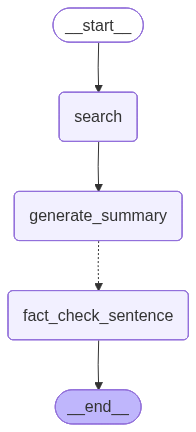

In [53]:
# 그래프 빌더 초기화
builder = StateGraph(OverallState)

# 노드 추가
builder.add_node("search", search_info)
builder.add_node("generate_summary", generate_summary)
builder.add_node("fact_check_sentence", fact_check_single_sentence)

# 순차 실행 엣지
builder.add_edge(START, "search")
builder.add_edge("search", "generate_summary")

# 조건부 엣지 (Send 사용)
builder.add_conditional_edges(
    "generate_summary",           # 시작 노드
    fact_check_sentences,         # 조건 함수 (Send 리스트 반환)
    ["fact_check_sentence"]
)

# 병렬 노드 → END
builder.add_edge("fact_check_sentence", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

---

### Step 9: 그래프 실행 및 결과 확인

In [54]:
# 사용자 질문
inputs = {
    "query": "기후 변화의 주요 원인은 무엇인가요?"
}

print("=" * 80)
print("🚀 리서치 어시스턴트 실행")
print("=" * 80)

# 그래프 실행
result = graph.invoke(inputs)

# 결과 출력
print("\n" + "=" * 80)
print("📊 최종 결과")
print("=" * 80)

print(f"\n🔍 검색 쿼리: {result['query']}")
print(f"\n📝 요약:\n{result['summary']}")
print(f"\n✅ 팩트체크 결과 ({len(result['fact_check'])}개 문장):")
print("-" * 80)

for i, check in enumerate(result['fact_check'], 1):
    print(f"\n{i}. [{check.score:.2f}] {check.sentence}")
    
    # 신뢰도 등급 표시
    if check.score >= 0.8:
        grade = "🟢 높음"
    elif check.score >= 0.5:
        grade = "🟡 중간"
    else:
        grade = "🔴 낮음"
    
    print(f"   신뢰도: {grade}")

🚀 리서치 어시스턴트 실행
🔍 검색 중: 기후 변화의 주요 원인은 무엇인가요?
📝 요약 생성 중...
🔀 4개 문장을 병렬 팩트체크합니다...
✅ 팩트체크 중: 요약:  
기후변화는 자연적 요인(태양에너지 변화, 지구 공전궤도 변화, 화산 폭발 등)과...
✅ 팩트체크 중: 산업혁명 이후 화석연료 사용 증가로 대기 중 이산화탄소 농도가 급격히 상승하였고, 이로 인...
✅ 팩트체크 중: 기후변화는 전 세계적으로 극한 기상 현상의 빈번한 발생과 환경·사회적 문제를 초래하며, 이...
✅ 팩트체크 중: 일상생활에서 에너지 절약, 자동차 사용 감소, 물 절약 등 작은 실천들이 이산화탄소 배출 ...

📊 최종 결과

🔍 검색 쿼리: 기후 변화의 주요 원인은 무엇인가요?

📝 요약:
요약:  
기후변화는 자연적 요인(태양에너지 변화, 지구 공전궤도 변화, 화산 폭발 등)과 인간 활동에 의한 인위적 요인(화석연료 연소로 인한 온실가스 증가, 도시화, 산림 파괴 등)에 의해 발생하며, 현재 진행 중인 온난화는 주로 인위적 요인이 주된 원인이다.  

산업혁명 이후 화석연료 사용 증가로 대기 중 이산화탄소 농도가 급격히 상승하였고, 이로 인한 온실효과가 태양에너지 변화보다 약 20배 이상 큰 영향을 미치고 있다.  

기후변화는 전 세계적으로 극한 기상 현상의 빈번한 발생과 환경·사회적 문제를 초래하며, 이를 완화하기 위해서는 개인과 국가 차원의 적극적인 대응과 실천이 필요하다.  

일상생활에서 에너지 절약, 자동차 사용 감소, 물 절약 등 작은 실천들이 이산화탄소 배출 감소에 기여할 수 있다.

✅ 팩트체크 결과 (4개 문장):
--------------------------------------------------------------------------------

1. [0.90] 요약:  
기후변화는 자연적 요인(태양에너지 변화, 지구 공전궤도 변화, 화산 폭발 등)과 인간 활동에 의한 인위적 요인(화석연료 연소로 인한 온실가스 증가, 도시화, 산림 파괴 등